# 보팅


<ipython-input-6-9210711e5581>:33: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


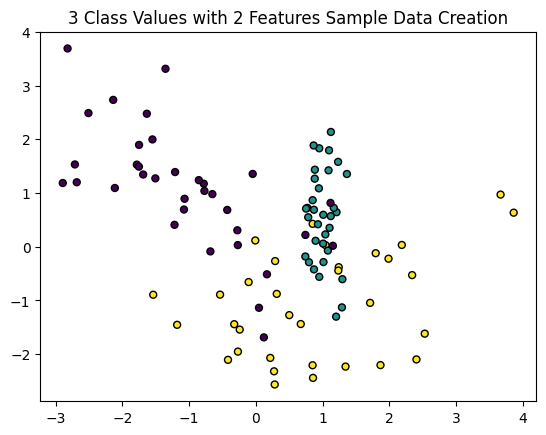

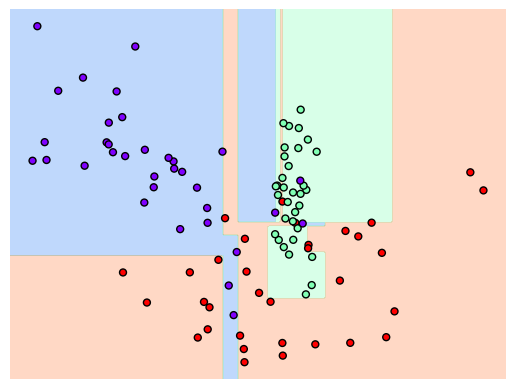

In [6]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('3 Class Values with 2 Features Sample Data Creation')

# 2차원 시각화를 위해서 피처는 2개, 클래스는 3가지 유형의 분류 샘플 데이터 생성
X_feature, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2, n_classes=3, n_clusters_per_class=1, random_state=0)

# 그래프 형태로 2개의 피처로 2차원 좌표 시각화, 각 클래스 값은 다른 색깔로 표시
plt.scatter(X_feature[:, 0], X_feature[:, 1], marker='o', c=y_labels, s=25, edgecolors='k')
# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()

    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()

    # 호출 파라미터로 들어온 training 데이타로 model 학습 .
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행.
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # contourf() 를 이용하여 class boundary 를 visualization 수행.
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)
dt_clf = DecisionTreeClassifier().fit(X_feature, y_labels)
visualize_boundary(dt_clf, X_feature, y_labels)

# 배깅

랜덤 포레스트 정확도: 0.9561


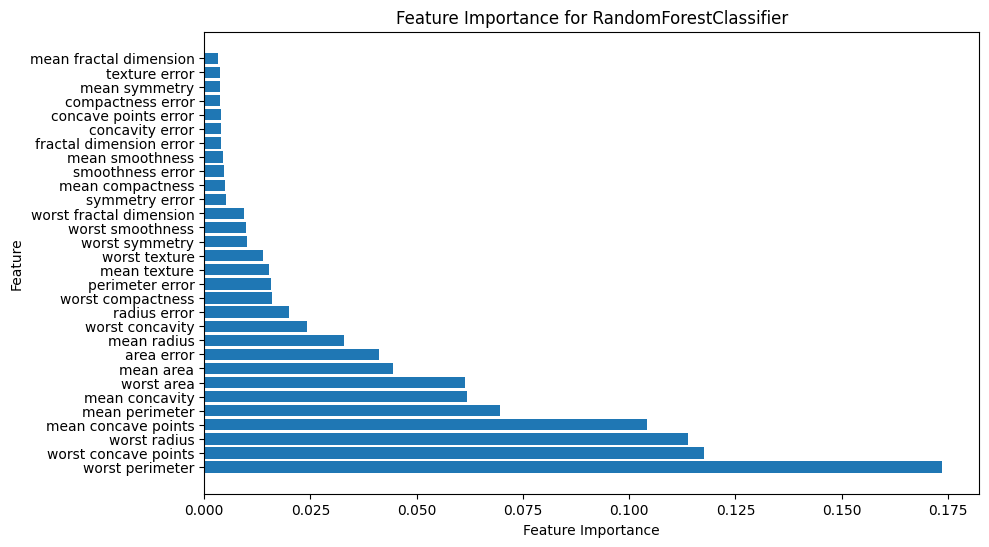

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   test_size=0.2, random_state=156)

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

# Get feature importances
feature_importances = rf_clf.feature_importances_
feature_names = cancer.feature_names

# Sort feature importances in descending order and get the corresponding feature names
sorted_idx = feature_importances.argsort()[::-1]
sorted_feature_names = feature_names[sorted_idx]
sorted_feature_importances = feature_importances[sorted_idx]

# Create a horizontal bar chart for feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for RandomForestClassifier')
plt.show()


# 부스팅

In [32]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np


dataset= load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target']=labels


print(dataset.target_names)
print(cancer_df['target'].value_counts())

X_features= cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:, -1]
## 학습, 검증용 데이터셋 비율 8 : 2
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

## X_train, y_train을 다시 9 : 1 비율로 분리
## => XGBoost가 제공하는 교차 검증 성능 평가 및 조기 중단을 수행하기 위함
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion= confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  f1 =f1_score(y_test,pred)
  roc_auc = roc_auc_score(y_test, pred_proba)

  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [30]:
from xgboost import XGBClassifier

## 모델 선언
xgb_clf = XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=3, eval_metric='logloss')

## 학습용 데이터, 검증용 데이터
evals = [(X_tr, y_tr), (X_val, y_val)]

## early stopping 적용
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=50,  eval_set=evals, verbose=True)

w_preds = xgb_clf.predict(X_test)
w_preds_proba = xgb_clf.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740, F1: 0.9740, AUC: 0.9961


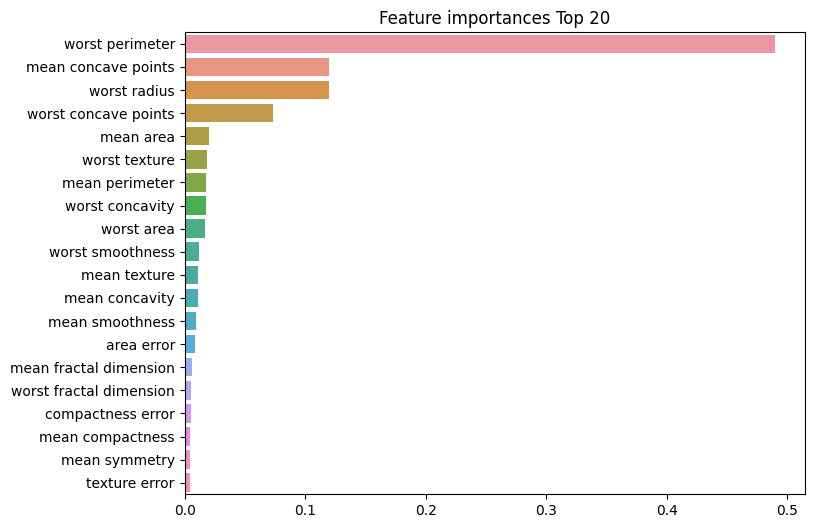

In [31]:
get_clf_eval(y_test, w_preds, w_preds_proba)


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = xgb_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()